# Analyzing Atrato's Portuguese Migrants 🇵🇹

In [1]:
from util import *
import pandas as pd, geopandas as gpd, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as gp, numpy as np, pylab as pl
%matplotlib inline

In [2]:
df = pd.read_excel('data/atrato-data.xlsx',
                   converters={"naturality_place_id":str,"naturality_city_id": str,
                               "naturality_state_id":str,"passport_emission_id":str})
df = df[df.nationality=="Portuguese"].reset_index(drop=True)

### Total of Migrants

In [3]:
print("There were {} Portuguese migrants in Atrato's Boarding Lists.".format(len(df)))

There were 195 Portuguese migrants in Atrato's Boarding Lists.


### Embarkation

In [4]:
embarked = df.query("embarked == 'Yes'")
not_embarked = df.query("embarked == 'No'")
print("Out of the {} Portuguese in boarding lists:\n\t- {} embarked in the Port of Lisbon"
      " \n\t- {} did not embark, a solo traveler and a family"
      .format(len(df), len(embarked), len(not_embarked)))
print("\nAccording to the newspaper 'O Economista', published on Jan 8,"
      "the Port of Lisbon Police had the {} arrested because they tried to embark without passports. "
      "The family actually had a passport emited at the Civil Government of Vila Real, "
      "maybe they lost it before embarking or the information in it was false.".format(len(not_embarked)))

Out of the 195 Portuguese in boarding lists:
	- 189 embarked in the Port of Lisbon 
	- 6 did not embark, a solo traveler and a family

According to the newspaper 'O Economista', published on Jan 8,the Port of Lisbon Police had the 6 arrested because they tried to embark without passports. The family actually had a passport emited at the Civil Government of Vila Real, maybe they lost it before embarking or the information in it was false.


In [5]:
solo = embarked["solo_id"].dropna().astype(int).nunique()
families = embarked["family_id"].dropna().astype(int).nunique()
print("Passengers were made up of:\n\t- {} families\n\t- {} solo travelers"
      .format(families, solo))

Passengers were made up of:
	- 31 families
	- 85 solo travelers


### Tickets

In [6]:
paid= embarked.query("contract == 'Paid'")
c_locadora = 5 # It's unknow which passengers were the ones brought for Companhia Locadora
w_c_tait = embarked.query("contract == 'W.C. Tait'")
print("Regarding Passenger Tickets:\n\t- {} paid for the passenger tickets\n\t- {} were brought by William C. Tait & Cia.\n\t\t- {} with subsidized tickets\n\t\t- {} were single portuguese hired as servants by Companhia Locadora Previdência Doméstica\nAll of them were in 3rd Class/Steerage"
      .format(len(paid)-c_locadora, len(w_c_tait) + c_locadora, len(w_c_tait), c_locadora))

Regarding Passenger Tickets:
	- 98 paid for the passenger tickets
	- 91 were brought by William C. Tait & Cia.
		- 86 with subsidized tickets
		- 5 were single portuguese hired as servants by Companhia Locadora Previdência Doméstica
All of them were in 3rd Class/Steerage


## Subsidized Migrants
Analyzing the Demographics of Subsidized Portuguese Migrants

### Family, Gender and Civil Status
Subsidized Passengers were made up of 23 families and no solo travelers.

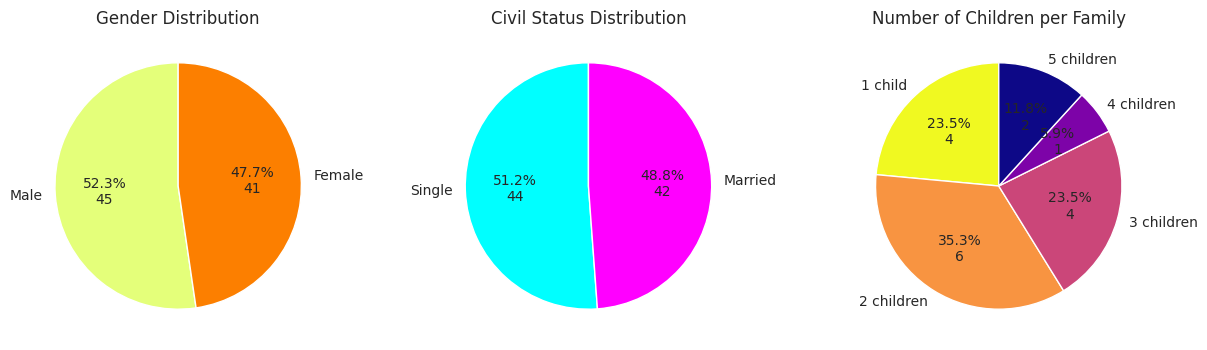

In [7]:
families = w_c_tait["family_id"].dropna().astype(int).nunique()
fig1, axes = plt.subplots(ncols=3)

gender = w_c_tait["gender"].to_frame("Gender").value_counts().to_frame("Total")
gender.plot.pie(title="Gender Distribution", figsize=(15,4), cmap="Wistia",y='Total',ylabel='',ax=axes[0],
                autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(w_c_tait)*prct_value/100)),
                shadow=False, startangle=90, labels=["Male","Female"]).get_legend().remove()

civil_status = w_c_tait["civil-status"].to_frame("Civil Status").value_counts().to_frame("Total")
civil_status.plot.pie(title="Civil Status Distribution", figsize=(15,4), cmap="cool", ax=axes[1],
                      autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(w_c_tait)*prct_value/100)),
                      shadow=False, startangle=90, labels=["Single","Married"], y='Total', ylabel='').get_legend().remove()

n_children = w_c_tait.query("role in ['Son','Daughter','Stepson','Stepdaughter']")
n_children = n_children['family_id'].value_counts().to_frame("Total")
num_children = n_children.reset_index(drop=True).value_counts().sort_index()
num_children.plot.pie(title="Number of Children per Family", figsize=(15,4), cmap="plasma_r", ax=axes[2],
                      autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(n_children)*prct_value/100)),
                      shadow=False, startangle=90,  labels=["1 child","2 children", "3 children", "4 children", "5 children"],
                      y='Total', ylabel='').get_legend()

### Age Pyramid

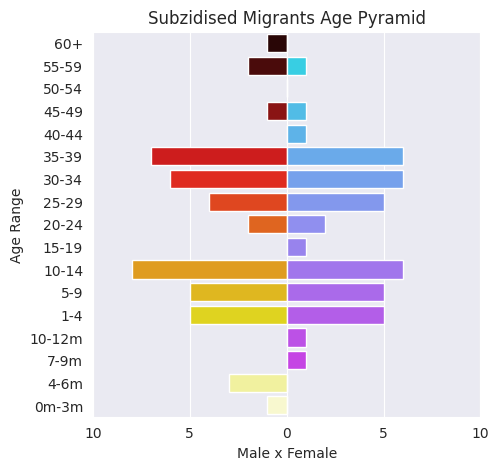

In [8]:
pyramid = generate_age_pyramid(w_c_tait)
plt.figure (figsize=(5,5))
male_axis = sns.barplot(x='male', y='age', data=pyramid, order=pyramid["age"], palette="hot")
female_axis = sns.barplot(x='female', y='age', data=pyramid, order=pyramid["age"], palette="cool")

plt.title("Subzidised Migrants Age Pyramid")
plt.xticks(ticks=[-10, -5, 0, 5, 10], labels=['10', '5','0', '5', '10'])
plt.xlabel("Male x Female"); plt.ylabel("Age Range");

### Naturality
The naturality of passangers brought by William C. Tait & Cia.:

#### Naturality per Distrito

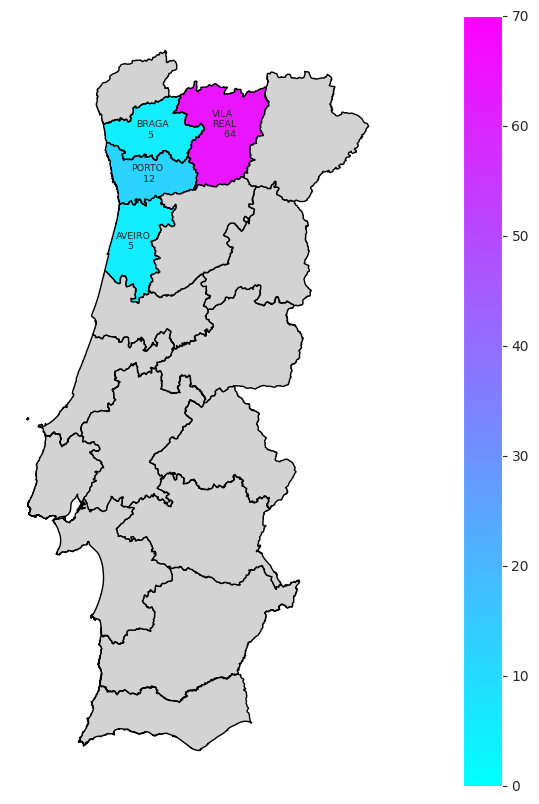

In [9]:
fig3, ax = plt.subplots()

distritos_map = generate_distritos_map(w_c_tait)
distritos_map.plot(column="count", cmap="cool",vmax=70, vmin=0, legend=True, ax=ax,
                   edgecolor="black", missing_kwds=dict(color="lightgrey", ))
generate_texts_distritos(distritos_map)

plt.axis("off"); plt.gcf().set_size_inches(20, 10)

#### Naturality per Concelho

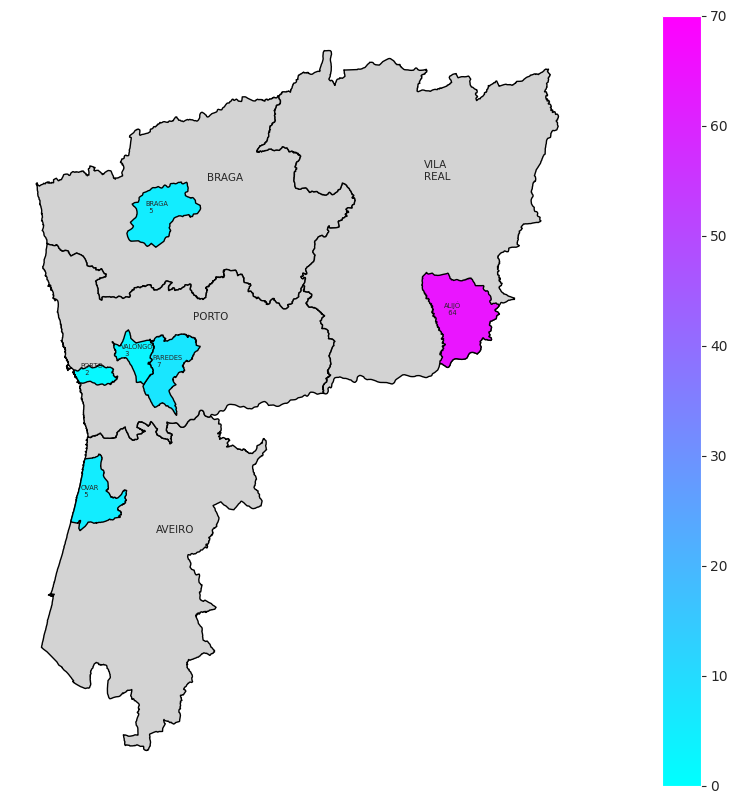

In [10]:
fig4, ax = plt.subplots()

distritos_concelhos_map = generate_distritos_map(w_c_tait,False)
concelhos_map = generate_concelhos_map(w_c_tait,False)
distritos_concelhos_map.plot(color="lightgrey", legend=True, edgecolor="black", ax=ax)
concelhos_map.plot(column="count", cmap="cool", vmax=70, vmin=0, ax=ax,
                   legend=True, edgecolor="black", missing_kwds=dict(color="lightgrey", ))
generate_texts_distrito_concelho(distritos_concelhos_map,concelhos_map)

plt.axis("off"); plt.gcf().set_size_inches(20, 10)

#### Naturality per Freguesia from the Concelho of Alijó

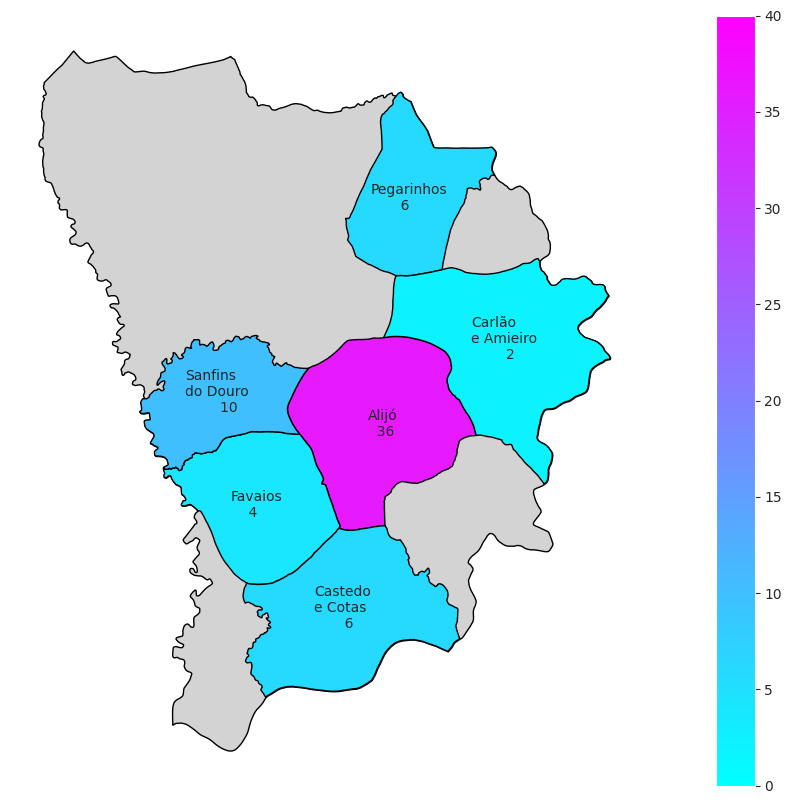

In [11]:
fig5, ax = plt.subplots()

alijo = w_c_tait.query("naturality_city == 'Alijó'")
alijo_concelhos_map = generate_concelhos_map(alijo,False)
alijo_freguesias_map = generate_freguesias_map(alijo,False)
alijo_concelhos_map.plot(color="lightgrey", legend=True, edgecolor="black", ax=ax)
alijo_freguesias_map.plot(column="count", cmap="cool",vmax=40, vmin=0, legend=True, ax=ax,
                          edgecolor="black", missing_kwds=dict(color="lightgrey", ))
generate_texts_alijo(alijo_freguesias_map)

plt.axis("off"); plt.gcf().set_size_inches(20, 10)

### Passaports
All passengers had their passports emited in the Governo Civil from their Distritos

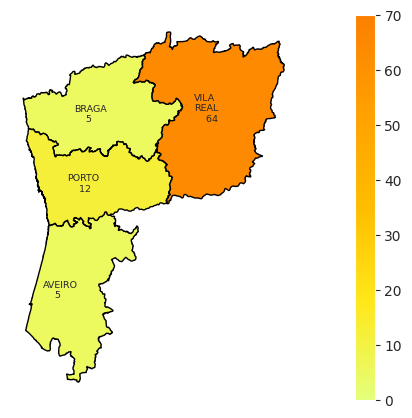

In [12]:
fig6, ax = plt.subplots()
plt.gcf().set_size_inches(15, 5)

passport_map = generate_passport_map(w_c_tait)
passport_map.plot(column = "count",cmap="Wistia", vmax=70, vmin=0, ax=ax,
                   legend=True, edgecolor="black", missing_kwds= dict(color = "lightgrey",))
generate_texts_distritos(passport_map)
plt.axis("off")
plt.show()

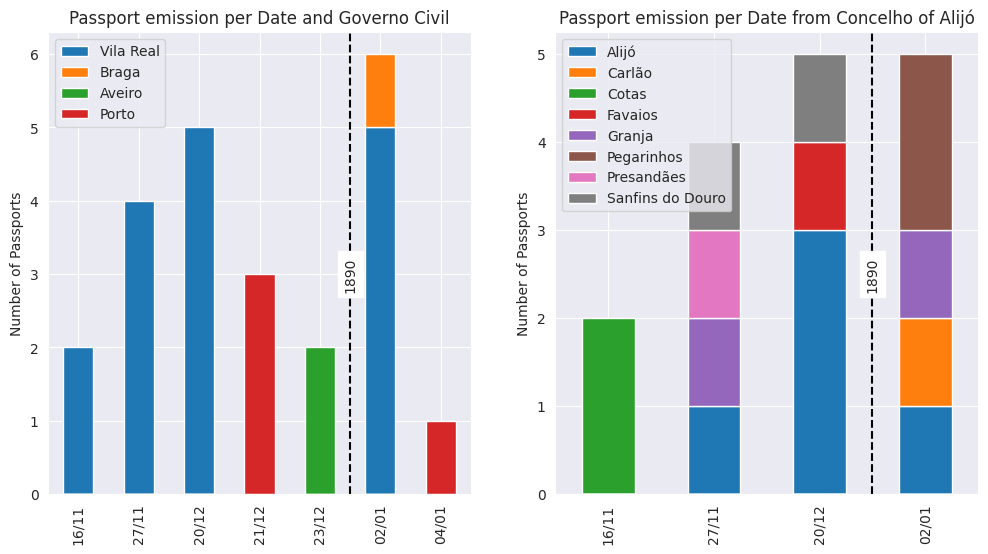

In [13]:
bearers = w_c_tait.query("role == 'Bearer'")
fig7, axes = plt.subplots(ncols=2, figsize=(12, 6))

passports = generate_passport_bar(bearers)
passports.plot(x='passport_date', kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Passports')
axes[0].set_title('Passport emission per Date and Governo Civil')
axes[0].axvline(x = 4.5, color = 'black', linestyle='dashed')
axes[0].text(4.5, 3, '1890', ha='center', va='center',rotation='vertical', backgroundcolor='white')
axes[0].set_xticklabels(['16/11','27/11','20/12','21/12','23/12','02/01','04/01'])


vila_real = bearers.query("passport_emission == 'Vila Real'")[["list_name", "passport_date","naturality_place"]]\
                   .sort_values(by='passport_date')
passports_alijo = generate_passport_bar_alijo(vila_real)
passports_alijo.plot(x='passport_date', kind='bar', stacked=True, ax=axes[1])
axes[1].set_xticklabels(['16/11','27/11','20/12','02/01'])
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Passports')
axes[1].set_title('Passport emission per Date from Concelho of Alijó')
axes[1].axvline(x = 2.5, color = 'black', linestyle='dashed')
axes[1].text(2.5, 2.5, '1890', ha='center', va='center',rotation='vertical', backgroundcolor='white');

### Arrival
On January 20th, 1890, the Atrato arrived at Rio de Janeiro.

In [14]:
hospedaria = w_c_tait.query("disembarked_hospedaria=='Yes'")
santa_casa = w_c_tait.query("disembarked_hospedaria =='No'")
print("Subsidized Passengers Debarkation:\n\t- {} in Hospedaria da Ilha das Flores\n\t- {} in Santa Casa da Misericórdia of Rio de Janeiro"
      .format(len(hospedaria), len(santa_casa)))

print("{} disembarked at Santa Casa for medical reasons, his wife {} went with him."
      "It is uncertain whether they eventually made it to the Hospedaria da Ilha das Flores, going foward we will assume they did."
      .format(santa_casa.list_name[25], santa_casa.list_name[26]))

Subsidized Passengers Debarkation:
	- 84 in Hospedaria da Ilha das Flores
	- 2 in Santa Casa da Misericórdia of Rio de Janeiro
Miguel dos Santos disembarked at Santa Casa for medical reasons, his wife Maria da Gloria went with him.It is uncertain whether they eventually made it to the Hospedaria da Ilha das Flores, going foward we will assume they did.


#### Departure from the Hospedaria da Ilha das Flores

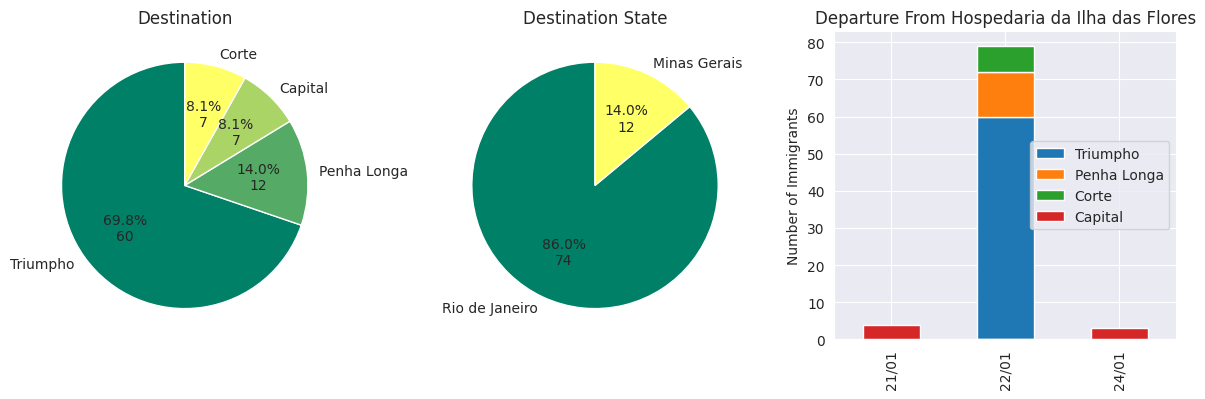

In [15]:
fig8, axes = plt.subplots(ncols=3, figsize=(12, 6))
destination = w_c_tait["destination"].to_frame("Destination").value_counts().to_frame("Total")
destination.plot.pie(title="Destination", figsize=(15,4), cmap="summer",y='Total',ylabel='',ax=axes[0],
                autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(w_c_tait)*prct_value/100)),
                shadow=False, startangle=90, labels=["Triumpho", "Penha Longa", "Capital", "Corte"]).get_legend().remove()

destination_UF = w_c_tait["destination_UF"].to_frame("Destination").value_counts().to_frame("Total")
destination_UF.plot.pie(title="Destination State", figsize=(15,4), cmap="summer",y='Total',ylabel='',ax=axes[1],
                        autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(w_c_tait)*prct_value/100)),
                        shadow=False, startangle=90, labels=["Rio de Janeiro", "Minas Gerais"]).get_legend().remove()

destination = generate_destination(w_c_tait)
destination.plot(x='destination_date', kind='bar', stacked=True, ax=axes[2])
axes[2].set_xticklabels(['21/01','22/01','24/01'])
axes[2].set_xlabel('')
axes[2].set_ylabel('Number of Immigrants')
axes[2].set_title('Departure From Hospedaria da Ilha das Flores');